In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import skew
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
from pyglmnet import GLM 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from pandas import ExcelWriter  #useful to write in excel

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [9]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [11]:
#Function for scatter plot
def scatplot(a,b):
    scatplotdata = pd.DataFrame({"x":a, "y":b})
    scatplotdata.plot(x = "x", y = "y", kind = "scatter")
    plt.show()
    return()

In [12]:
# Function for Distribution and skewness
def distskew(dataset,feature):
    fig = plt.figure()
    sns.distplot(dataset[feature], fit=norm);
    plt.show()
    return("Skewness = ",skew(dataset[feature].dropna()))

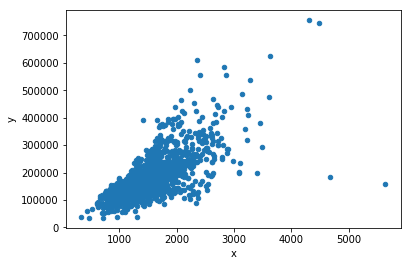

In [13]:
scatplot(train["GrLivArea"],train["SalePrice"])
#distskew(train,"ScreenPorch")
train = train.drop(train[train['GrLivArea'] > 4000].index)

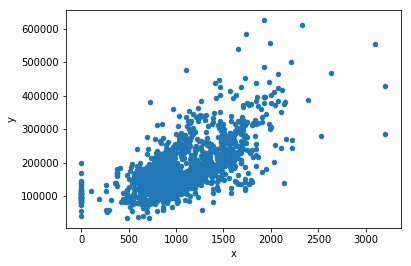

In [14]:
scatplot(train["TotalBsmtSF"],train["SalePrice"])
train = train.drop(train[train['TotalBsmtSF']> 6000].index)

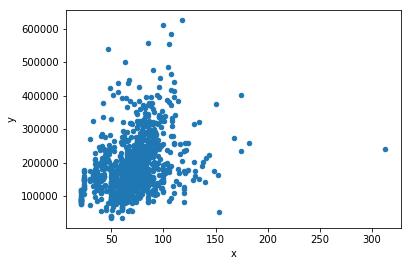

In [15]:
#Lot frontage
scatplot(train["LotFrontage"],train["SalePrice"])
train = train.drop(train[train['LotFrontage']>150].index)

In [16]:
print(train['LotFrontage'].isnull().sum())

259


In [17]:
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())

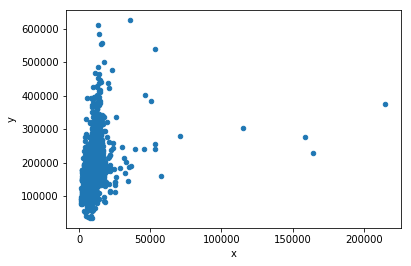

()

In [18]:
#Lot Area
scatplot(train["LotArea"],train["SalePrice"])

In [19]:
train = train.drop(train[train['LotArea']>50001].index)

In [20]:
#Concatenating Data
all_data = pd.concat((train.loc[:,'Id':'SaleCondition'],
                      test.loc[:,'Id':'SaleCondition']))

In [21]:
print("\n train",train.shape)
print("\n test",test.shape)
print("\nall_data",all_data.shape)



 train (1439, 81)

 test (1459, 80)

all_data (2898, 80)


In [22]:
#Convert data with numerical categories into categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [23]:
#Get all numerical feature coulmns
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [24]:
#Get all Categorical data columns:
categorical_features = pd.DataFrame(all_data.describe(include = ['O'])).columns



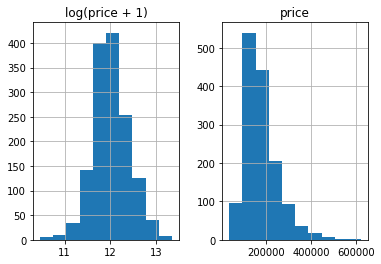

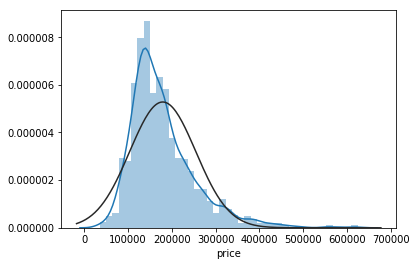

('Skewness = ', 1.5743193228019343)

In [25]:
#Checking og transform vs original
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()
plt.show()
distskew(prices, 'price')

In [26]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

# Data Cleaning

In [27]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data)

              Missing Ratio
PoolQC            99.758454
MiscFeature       96.445825
Alley             93.202208
Fence             80.365769
FireplaceQu       48.930297
LotFrontage        7.832988
GarageFinish       5.452036
GarageYrBlt        5.452036
GarageQual         5.452036
GarageCond         5.452036
GarageType         5.383023
BsmtExposure       2.829538
BsmtCond           2.829538
BsmtQual           2.795031
BsmtFinType2       2.760524
BsmtFinType1       2.726018
MasVnrType         0.828157
MasVnrArea         0.793651
MSZoning           0.138026
BsmtFullBath       0.069013
BsmtHalfBath       0.069013
Utilities          0.069013
Functional         0.069013
Exterior2nd        0.034507
Exterior1st        0.034507
SaleType           0.034507
BsmtFinSF1         0.034507
BsmtFinSF2         0.034507
BsmtUnfSF          0.034507
Electrical         0.034507


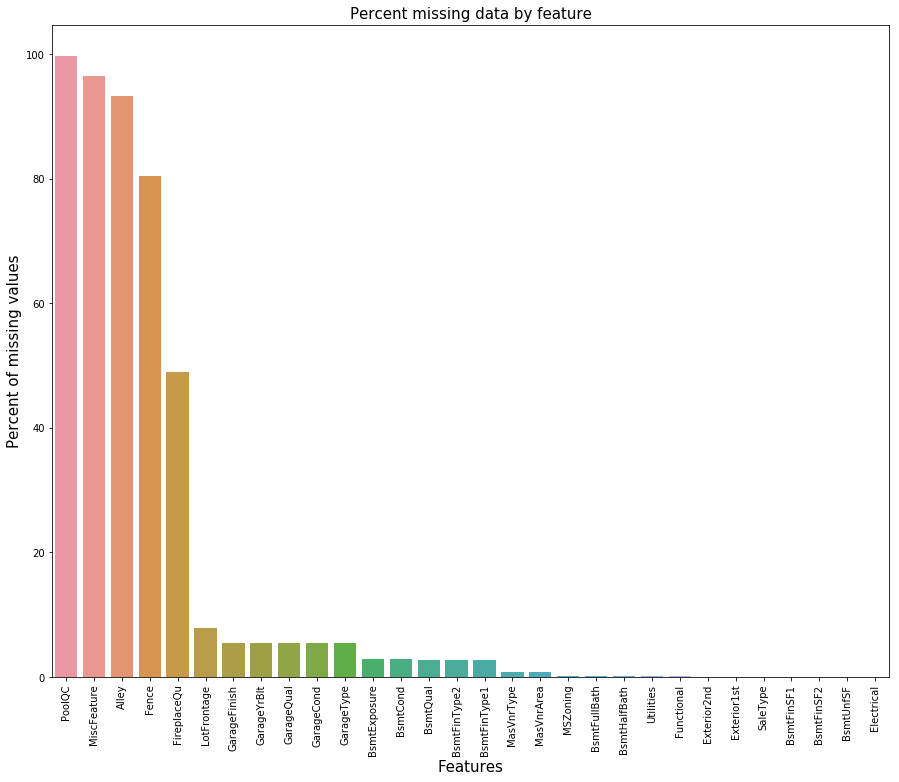

In [28]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

In [29]:
#Imputing missing values
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)    

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [30]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


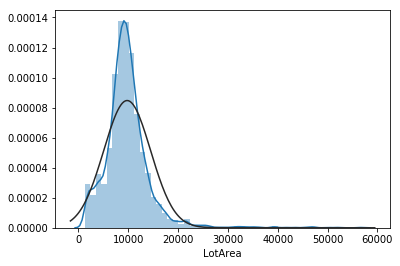

In [31]:
#Lot area
distskew(all_data, 'LotArea')

#Apply log transform
all_data['LotArea']=np.log1p(all_data['LotArea'])

In [32]:
#Feature Engineering
all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
train["TotBsmtFin"] = train["BsmtFinSF1"] + train["BsmtFinSF2"]
                 
all_data = all_data.drop("BsmtFinSF1",1)
all_data = all_data.drop("BsmtFinSF2",1)

all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]
train["TotBath"] = train["FullBath"] + 0.5*train["HalfBath"] + train["BsmtFullBath"] + 0.5*train["BsmtHalfBath"]

all_data = all_data.drop("FullBath",1)
all_data = all_data.drop("HalfBath",1)
all_data = all_data.drop("BsmtFullBath",1)
all_data = all_data.drop("BsmtHalfBath",1)


In [33]:
print("all_data dim:",all_data.shape)

all_data dim: (2898, 75)


In [34]:
# Add the living areas and basement aread to create a new feature TotArea
all_data["TotArea"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
train["TotArea"] = train["GrLivArea"] + train["TotalBsmtSF"]


print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)
all_data["HasFirePlace"] =all_data["Fireplaces"]>0 
all_data["HasWoodDeck "] =all_data["WoodDeckSF"]>0

all_data dim:  (2898, 76)


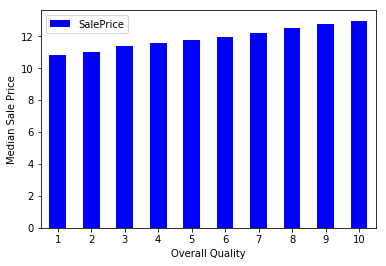

In [35]:
quality_pivot = train.pivot_table(index='OverallQual',
                                    values='SalePrice',aggfunc=np.median)
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [36]:
all_data['enc_street'] = pd.get_dummies(all_data.Street, drop_first=True)

In [37]:
print ('Encoded: \n') 
print (all_data.enc_street.value_counts())

Encoded: 

1    2887
0      11
Name: enc_street, dtype: int64


In [38]:
#Refresh the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Here we've changed the train[numeric_feats] with all_data[numeric_feats]
#because we are working on all_data and train is just a part of it

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#exctract the features with skewness higher than 75%
skewed_feats = skewed_feats[skewed_feats > 0.1]
skewed_feats = skewed_feats.index

#log transform skewed numeric features with skewness > 75%:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

train[skewed_feats] = np.log1p(train[skewed_feats])


print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

all_data dim:  (2898, 79)


# Drop features that dont help by looking at the heatmap

In [39]:
all_data = all_data.drop("BsmtFinType1",1)
all_data = all_data.drop("2ndFlrSF",1)
all_data = all_data.drop("BedroomAbvGr",1)

all_data = all_data.drop("LowQualFinSF",1)
all_data = all_data.drop("3SsnPorch",1)
all_data = all_data.drop("PoolArea",1)

all_data = all_data.drop('Condition2',1)

print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

all_data dim:  (2898, 72)


# Get dummies and drop NA

In [40]:
dummies = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.median())

In [41]:
all_data.shape

(2898, 318)

## Create the new X_train and X_test with all the selected features

In [42]:
# Normalize the features (this does not seem to help: increases error)
#all_data = all_data.apply(lambda x: x/np.sqrt(sum(x**2)))

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice#already log transformed
X_train['SalePrice'] = train.SalePrice

# save 
#X_train.to_csv("C:/Users/work/Desktop/DA/X_train_v2.csv")
#X_test.to_csv("C:/Users/work/Desktop/DA/X_test_v2.csv")

X_train = X_train.drop("SalePrice",1)
print("\nShape check\n train.shape: ",train.shape)
print(" X_Train dim: ",X_train.shape)
print("\n X_test dim: ",X_test.shape)


Shape check
 train.shape:  (1439, 84)
 X_Train dim:  (1439, 318)

 X_test dim:  (1459, 318)


C:\Users\abhis_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Post feature analysis

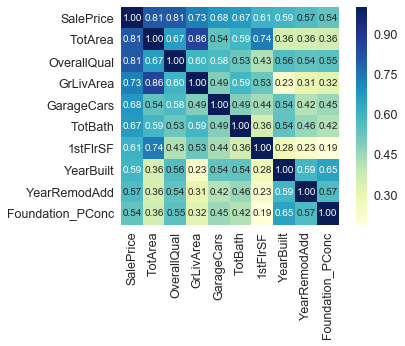

In [43]:
#The analysis of the correlation between the new feature (from get_dummies) and the sale price 
X_check=X_train.assign(SalePrice=train.SalePrice, index=X_train.index)
corrmat = X_check.corr()
#Correlation matrix with Log of Sale Price
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
#cols = corrmat.nsmallest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(X_check[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [46]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Fit Model: Ridge (L2 Norm)

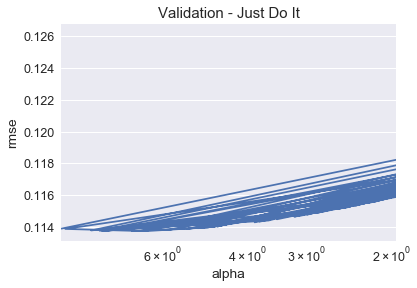

The min value of Ridge is  0.11372893297987234


In [50]:
#first evaluation of the regular linear regression method:
#Ridge:
model_ridge = Ridge()
alphas = 10**np.random.uniform(-1,1, size=100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
           for alpha in alphas]
    
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
#Added log scale to have a better view of the minimum
plt.xscale("log")
plt.show()
print("The min value of Ridge is ",cv_ridge.min())

In [51]:
#Choose the best alpha by taking the alpha that give the lowest rmse
best_alpha = 0.57
# Now fit Ridge model
model_ridge = Ridge(alpha = best_alpha).fit(X_train, y)

# Fit Model: Lasso (L1 Norm)

C:\Users\abhis_000\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abhis_000\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abhis_000\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abhis_000\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You migh

The min value of Lasso is  0.11080179506074302
Lasso picked 127 variables and eliminated the other 191 variables


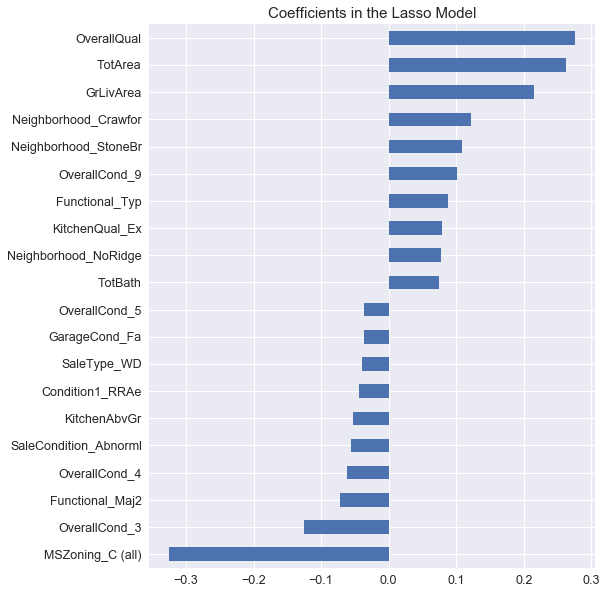

In [52]:
#Lasso:
model_lasso = LassoCV(alphas = 10**np.random.uniform(-6,1,size=100)).fit(X_train, y)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())


#Lasso choose performs also feature selection 

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Let's look to the most important coefficients:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")  
plt.show()  

#Also note that unlike the feature importance you'd get from a random forest 
#these are actual coefficients in your model - so you can say precisely 
#why the predicted price is what it is. 
#The only issue here is that we log_transformed both the target 
#and the numeric features 
#so the actual magnitudes are a bit hard to interpret.


#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds_log = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
#let's return to "original" value from the log:
preds_val = np.expm1(preds_log)

solution = pd.DataFrame({"SalePrice":model_lasso, "id":test.Id})
solution.to_csv("MDV_Lasso_v1.csv", index = False)


preds_log["residuals"] = preds_log["true"] - preds_log["preds"]



#preds_log.plot(x = "preds", y = "true",kind = "scatter")
#plt.title('Log Value ')
#plt.show()

#
#preds_val["residuals"] = preds_val["true"] - preds_val["preds"]
#preds_val.plot(x = "preds", y = "residuals",kind = "scatter")
#plt.title('Original Value in $')
#plt.show()

## Fit model: XGBoost

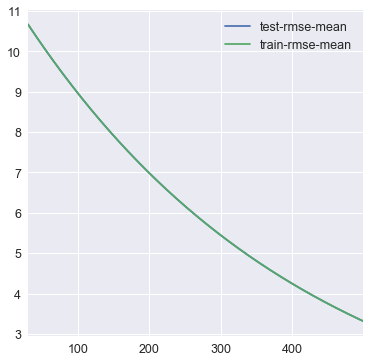

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0025, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=14000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
#Let's add an xgboost model to our linear model to see 
#if we can improve our score:

#y = preds_log["residuals"]
    
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

# params = {"max_depth":2, "eta":0.1}
params = {"learning_rate":0.0025,
 "n_estimators":20000,
 "max_depth":2,
 "min_child_weight":4,
 "reg_alpha":0.57,
 "reg_lambda":0.98,
 "gamma":0.0,
 "subsample":0.6,
 "colsample_bytree":0.55,
 "objective":'reg:linear',
 "nthread":4,
 "scale_pos_weight":1,
 "seed":15}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

#the params were tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=14000, max_depth=2, learning_rate=0.0025) 
model_xgb.fit(X_train, y)

# Now fit GLM net model

In [ ]:
# model_glm = GLM(distr='gaussian')
# scaler1 = StandardScaler().fit(X_train)
# scaler2 = StandardScaler().fit(X_test)
# model_glm.fit(scaler1.transform(X_train), y)

C:\Users\abhis_000\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\abhis_000\Anaconda3\lib\site-packages\pyglmnet\pyglmnet.py:653: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(DL[-1] / L[-1]) < tol:
C:\Users\abhis_000\Anaconda3\lib\site-packages\pyglmnet\pyglmnet.py:652: RuntimeWarning: invalid value encountered in double_scalars
  DL.append(L[-1] - L[-2])
C:\Users\abhis_000\Anaconda3\lib\site-packages\pyglmnet\pyglmnet.py:262: RuntimeWarning: overflow encountered in square
  logL = -0.5 * 1. / n_samples * np.sum((y - l)**2)
C:\Users\abhis_000\Anaconda3\lib\site-packages\pyglmnet\pyglmnet.py:280: RuntimeWarning: overflow encountered in double_scalars
  L2penalty = np.linalg.norm(beta, 2) ** 2


# Now combine the models for final prediction

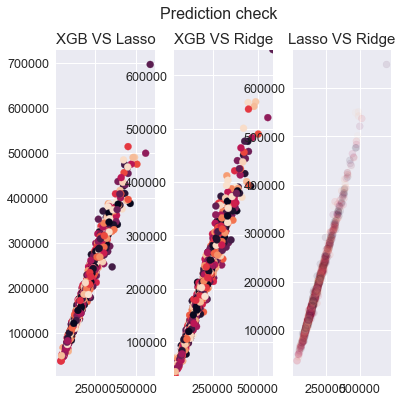

In [56]:
from matplotlib import gridspec

xgb_preds = np.expm1(model_xgb.predict(X_test))
ridge_preds = np.expm1(model_ridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

#glm_preds = np.expm1(model_glm.predict(scaler2.transform(X_test)))
predictions_lasso = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
#predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
#plt.show()

predictions_ridge = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})

lasso_vs_ridge = pd.DataFrame({"lasso":lasso_preds, "ridge":ridge_preds})

fig = plt.figure()
col =  np.random.rand(1459)


fig.suptitle("Prediction check", fontsize=16)
ax = plt.subplot("131")
ax.set_title("XGB VS Lasso")
ax.scatter(xgb_preds,lasso_preds, c=col)

#axes = plt.gca()
#ax.set_xlim([xmin,xmax])
#axes.set_ylim([ymin,ymax])
ax = plt.subplot("132")
ax.set_title("XGB VS Ridge")
ax.scatter(xgb_preds,ridge_preds, c=col)
ax.autoscale(tight=True)

ax = plt.subplot("133")
ax.set_title("Lasso VS Ridge")
ax.scatter(lasso_preds,ridge_preds,alpha=.1, c=col)

plt.show()



#predictions_ridge = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})
#predictions.plot(x = "xgb", y = "ridge", kind = "scatter")
#plt.show()



#Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves 
#the score although in this case it doesn't help that much.

In [61]:
#This last step should be performed after the evaluation of the results of Robert's models.
#for now it is up to you how to proceed for your feature engineering evaluation. I will use lasso/ridge.


#preds = 0*lasso_preds + 1*ridge_preds + 0*xgb_preds
preds = 0.6*lasso_preds + 0.4*xgb_preds
#preds = lasso_preds
#preds = ridge_preds
#preds= xgb_preds

solution = pd.DataFrame({"SalePrice":preds,"id":test.Id})
solution.to_csv("C:/Users/abhis_000/Desktop/soln1.csv", index = False)

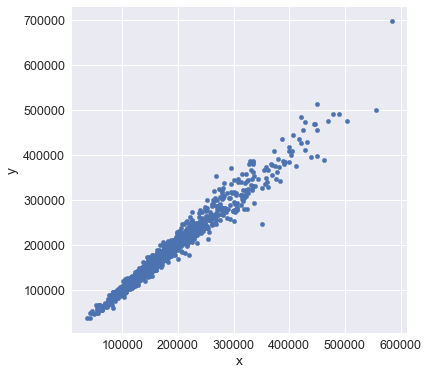

()

In [60]:
scatplot(xgb_preds,lasso_preds)

#### The project performance with different models is shown below. Elastic net performs better among all the ensambling methods and respective individual models


In [ ]:
from IPython.display import Image
Image(filename='IMG-20180427-WA0007.jpg')

#### The top scoring models Kaggle ranking is shown below 

In [ ]:
Image(filename='IMG-20180427-WA0008.jpg')